In [7]:
import numpy as np
import matplotlib.pylab as plot
import grb_catalogs
from astropy.cosmology import Planck15 as cosmo
import tao_planning_sims
import os.path
import fit_lc
import fit_functions
from astropy.io import ascii

In [8]:
grbox=grb_catalogs.load_GRBOX(nointernet=True)
bat=grb_catalogs.load_BAT()

In [9]:
def sample(grbox,bat):

#    grbox=grb_catalogs.load_GRBOX(nointernet=True)

    z=np.zeros(len(grbox))
    mask=grbox['z'].mask
    for i in range(len(grbox)):
        if (mask[i]==False) and (grbox['z'][i] != 'low'):
            z[i]=float(grbox['z'][i])

    w=np.where(bat['T90']!='N/A')
    bat=bat[w]
    t90=np.array(bat['T90']).astype('float')

    # replace some T90's with those in Fong et al. 2015 (short with long soft tails)
    lsgrbs=np.array(['GRB050724','GRB061006','GRB061210','GRB070714B','GRB070729','GRB071227','GRB090510'])
    lst90=np.array([1.99,0.4,0.2,1.99,0.9,1.8,0.3])
    m1,m2=grb_catalogs.match_catalogs_name(bat['GRBname'],lsgrbs)
    t90[m1]=lst90[m2]

    m1,m2=grb_catalogs.match_catalogs_name(np.core.defchararray.add('GRB',grbox['GRB']),bat['GRBname'])
#    s=np.where((t90[m2] <= 2.) & (t90[m2] > 0))# & (z[m1]>0))
    sGRBs=bat['GRBname'][m2]#[s]

#    print '# of sGRBs = ',len(s[0])

# D'Avanzo (2014) flux limited sample
#     dagrbs=np.core.defchararray.add('GRB',np.array(['051221A','060313','061201','070714B',\
#         '080123','080503','080905A','090426','090510','090515','100117A','100625A','101219A','111117A','130515A','130603B']))
    dagrbs=np.core.defchararray.add('GRB',np.array(['051221A','070714B',\
        '080123','080905A','090426','090510','100117A','100625A','100816A','101219A','111117A','130603B']))
    daz=np.array([0.5465,0.923,0.495,0.122,2.609,0.903,0.915,0.452,0.805,0.718,1.3,0.356])
    
    t90=t90[m2]#[s]
    z=z[m1]#[s]
    w0=np.where(z==0.)[0]
    #z[w0]=0.5  # if using those without z
    lumdist=cosmo.luminosity_distance(z).value
    pc2cm=3.08568025e18
    dist=lumdist*1e6*pc2cm
    distgw=190e6*1.5**2*pc2cm  ## 427.5 Mpc
    zgw=grb_catalogs.dist2z(427.5)
    dadist=cosmo.luminosity_distance(daz).value*1e6*pc2cm
#    print distgw,dadist
#    m1,m2=grb_catalogs.match_catalogs_name(sGRBs,dagrbs)
#     m1=m1[np.argsort(np.array(sGRBs[m1]))]
#     m2=m2[np.argsort(dagrbs[m2])]
#     m1=np.sort(m1)
#     m2=np.sort(m2)
#    print m1,m2
#     m1=m1[np.sort(sGRBs[m1])]
#     m2=m2[np.sort(dagrbs[m2])]
#    print sGRBs[m1],dagrbs[m2]
#     sGRBs=sGRBs[m1]
#     z=z[m1]
    return dagrbs,daz,dadist#sGRBs,dagrbs,z,zgw,dist,distgw

In [10]:
#sGRBs,dagrbs,z,zgw,dist,distgw=sample(grbox,bat)
sGRBs,z,dist=sample(grbox,bat)
print sGRBs,z,dist,len(z)
pc2cm=3.08568025e18
distgw=190*1.5**2*1e6*pc2cm
zgw=grb_catalogs.dist2z(427.5)

['GRB051221A' 'GRB070714B' 'GRB080123' 'GRB080905A' 'GRB090426'
 'GRB090510' 'GRB100117A' 'GRB100625A' 'GRB100816A' 'GRB101219A'
 'GRB111117A' 'GRB130603B'] [0.5465 0.923  0.495  0.122  2.609  0.903  0.915  0.452  0.805  0.718
 1.3    0.356 ] [1.00196473e+28 1.89874701e+28 8.89741631e+27 1.81533818e+27
 6.79097418e+28 1.84823689e+28 1.87850951e+28 7.98360660e+27
 1.60493583e+28 1.39526089e+28 2.89666299e+28 6.02604482e+27] 12


In [11]:
#sGRBs,dagrbs,z,zgw,dist,distgw=sample()

grbdir='/Users/jracusin/Swift/GRBfits/GRBs/'
oldgrbdir='/Users/jracusin/GRBs/'
outdir='/Users/jracusin/TAP/'
taodir='/Users/jracusin/TAO/simulations/'


In [20]:
def plot_sGRBs(distgw_mpc):
    
    pc2cm=3.08568025e18
    distgw=distgw_mpc*1e6*pc2cm
    zgw=grb_catalogs.dist2z(distgw_mpc)
    
    eng=np.linspace(0.3,10.,100)
    de=eng[1]-eng[0]
    wtao=np.where((eng >=0.3) & (eng <= 5.0))

    ngrbs=len(sGRBs)

    plot.figure()

    fscaled_100=[]

    for i in range(ngrbs):
        p={}
        sp={}
        if (os.path.exists(grbdir+sGRBs[i]+'/lc_fit_out_py_int1.dat') & os.path.exists(oldgrbdir+sGRBs[i])\
            & os.path.exists(oldgrbdir+sGRBs[i]+'') & (sGRBs[i] != 'GRB100628A') & (sGRBs[i] != 'GRB140311B')):
            p=fit_lc.read_lcfit(dir=grbdir+sGRBs[i]+'/')
            sp=fit_lc.read_specfit(dir=oldgrbdir+sGRBs[i]+'/')
            if (p != {}) & (sp != {}):

                r=i#rr[i]#int(np.random.uniform()*nsims)
                linestyle='-'

            # scale by distance, and k-correct from 0.3-10 keV to 0.3-5.0 keV
                if 'PC' in sp.keys(): spec=sp['PC'] 
                else: spec=sp['WT']
                lc=fit_lc.read_lc('/Users/jracusin/Swift/GRBfits/GRBs/'+sGRBs[i]+'/')
                conv=np.sum(fit_functions.pow(eng[wtao],*[1.,spec.gamma])*de)/np.sum(fit_functions.pow(eng,*[1.,spec.gamma])*de)
                k1=grb_catalogs.kcorr(0.3,10.,0.3,5.0,-spec.gamma,z[i])
                k2=grb_catalogs.kcorr(0.3,5.0,0.3,5.0,-spec.gamma,zgw)

                if distgw_mpc == 0:
                    conv=spec.flux/spec.rate*4.*np.pi*dist[i]**2/k1*k2*conv   #if at z=0
                else:
                    conv=spec.flux/spec.rate*4.*np.pi*dist[i]**2/k1*k2*conv  #scale to dist


                #                conv=spec.flux/spec.rate*4.*np.pi*dist[i]**2/k1*conv
    #            conv=conv*k2/(4.*np.pi*distgw**2)
#                print conv
                t=np.logspace(min(np.log10(lc['Time'])),max(np.log10(lc['T_+ve'])),100)/(1.+z[i])
    #            fscaled=fit_functions.call_function(p.model,t/(1.+z[i])*(1.+zgw),*p.par)*conv
                fscaled=fit_functions.call_function(p.model,t/(1.+z[i]),*p.par)*conv

#                print sGRBs[i],z[i]
                color='blue'
                fscaled_100.append(tao_planning_sims.loginterpol(t,fscaled,100.))
                plot.plot(t,fscaled,color=color,linestyle=linestyle)

#    print np.median(fscaled_100)

    plot.xscale('log')
    plot.yscale('log')
    plot.xlabel('Time (s)')
    #plot.ylim([1e-13,1e-5])
    plot.xlim([10,1e6])
    #plot.ylabel(r'0.3 - 5 keV Flux (erg cm$^{-2}$ s$^{-1}$)')
    plot.ylabel(r'0.3 - 5 keV Luminosity (erg s$^{-1}$)')
    ax=plot.gca()
    ax.get_yaxis().set_tick_params(direction='in',which='both')
    ax.get_xaxis().set_tick_params(direction='in',which='both')
    plot.title('sGRB X-ray afterglows scaled to '+str(distgw_mpc)+' Mpc')
    #	plot.title('sGRB X-ray afterglows scaled to 130 Mpc')
    #	plot.title('sGRB X-ray afterglows scaled to 200 Mpc')
    plot.savefig(outdir+'shb_plot.pdf')
    #plot.savefig('shb_plot.eps')
    #plot.savefig(outdir+'shb_plot.png')
    plot.show()

/Users/jracusin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


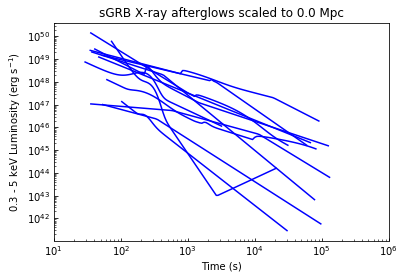

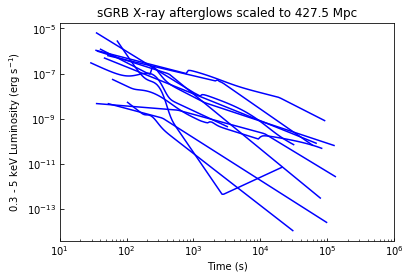

In [21]:
plot_sGRBs(0.)
plot_sGRBs(427.5)